# Dynamic Time Warping on Stock Data

In [1]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
yearRange = 5
rawAppleDF = pd.read_csv('./Data/Stocks/aapl.us.txt')
appleDF = rawAppleDF[-365 * yearRange:].reset_index(drop=1)
appleDF

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-08-16,31.725,32.020,31.582,31.714,88596378,0
1,2010-08-17,32.030,32.609,31.911,32.267,117743597,0
2,2010-08-18,32.342,32.614,32.219,32.408,94319941,0
3,2010-08-19,32.372,32.461,31.847,32.001,118845562,0
4,2010-08-20,31.933,32.516,31.887,31.969,106898327,0
...,...,...,...,...,...,...,...
1820,2017-11-06,171.750,174.360,171.100,173.630,34901241,0
1821,2017-11-07,173.290,174.510,173.290,174.180,24424877,0
1822,2017-11-08,174.030,175.610,173.710,175.610,24451166,0
1823,2017-11-09,174.480,175.460,172.520,175.250,29533086,0


## Pre-Processing

In [3]:
def dtwDist(a, b):
    distance, path = fastdtw(a, b, dist=euclidean)
    return distance

#### Library testing

In [4]:
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])

distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
print(path)
print()

dist2, path2 = fastdtw(x, y)
print(dist2) 
print(path2)

2.8284271247461903
[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]

4.0
[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]


#### Data Splitting
Using the close feature we will split the time series in distinct tlen day periods, this will allow us to create our x (percent change series) and y (resulting percent change) data. Each series will contain nlen elements.

In [5]:
timeSeries = []
numDays = 10
for i in range(numDays, len(appleDF), numDays):
    percentChange = appleDF['Close'].iloc[i - numDays : i].pct_change()[1:].values * 100
    result = appleDF['Close'].iloc[i - numDays : i + 1].pct_change()[-1:].values * 100
    timeSeries.append((percentChange, result[0]))

In [6]:
timeSeries[0]

(array([ 1.7437094 ,  0.43697896, -1.25586275, -0.09999688, -1.53586287,
        -2.38897007,  1.23673762, -1.07374783,  0.55569999]),
 0.36518760301198494)

## Get DTW Distances
Using the dtwDist function we will get the distance metric for  each series against every other series. Once we have the data, we drop all the series that  have a distance of 0 since they represent the same series. We will also sort the data to view only series that are in chronological order.

In [7]:
distPairs = []
for i in range(len(timeSeries)):
    for j in range(len(timeSeries)):
        distance = dtwDist(timeSeries[i][0], timeSeries[j][0])
        distPairs.append((i, j, distance, timeSeries[i][1], timeSeries[j][1]))

In [8]:
rawDistanceDF = pd.DataFrame(distPairs, columns=['A', 'B', 'Distance', 'A Return', 'B Return'])

#### Prune Distance Pairs

In [9]:
filteredDistanceDF = rawDistanceDF[rawDistanceDF['Distance'] > 0].sort_values(['A', 'B']).reset_index(drop=1)
orderedDistanceDF = filteredDistanceDF[filteredDistanceDF['A'] < filteredDistanceDF['B']]

In [10]:
dwtDistanceLimit = 7

goodDistanceDF = orderedDistanceDF[(orderedDistanceDF['Distance'] <= dwtDistanceLimit) & (orderedDistanceDF['A Return'] > 0)]
goodDistanceDF

,A,B,Distance,A Return,B Return
4,0,5,6.691123,0.365188,-0.796530
6,0,7,6.890082,0.365188,0.880938
10,0,11,6.792305,0.365188,0.889000
16,0,17,5.826422,0.365188,0.547951
25,0,26,5.256759,0.365188,-1.731954
...,...,...,...,...,...
31491,173,179,6.183851,0.865948,0.348972
31492,173,180,6.682555,0.865948,-0.051384
32032,176,177,6.719067,0.371771,1.809439
32034,176,179,4.937150,0.371771,0.348972


In [11]:
bestDay = max(np.array(timeSeries)[:, 1])
bestDay

7.206242574475286

#### Plot Best Return Value

In [12]:
bestIndex = -1
for i in range(len(timeSeries)):
    if timeSeries[i][1] == bestDay:
        bestIndex = i

(array([-0.30455773, -3.82593848, -3.62998308,  1.72862962, -0.76827301,
         0.01140657, -1.10916271, -2.09759965,  0.39316743]),
 7.206242574475286)

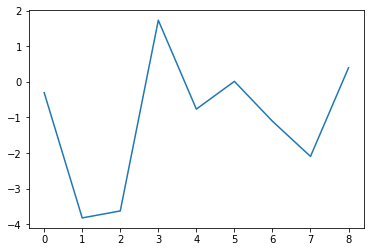

In [13]:
plt.plot(np.arange(numDays-1), timeSeries[bestIndex][0])
timeSeries[bestIndex]

In [14]:
excluded = {}
returnList = []
def getReturns(r):
    if excluded.get(r['A']) is None:
        if r['B Return'] < 0:
            excluded.update({r['A'] : 1})
        else:
            returnList.append((r['B Return'], r['A Return'], r['A'], r['B']))
            
goodDistanceDF.apply(getReturns, axis=1)
returnList

[(0.889000045473165, 0.8809383588535669, 7.0, 11.0),
 (0.857504334379855, 1.340137352155657, 16.0, 18.0),
 (0.2216354507271534, 0.857504334379855, 18.0, 46.0),
 (0.20093290276281817, 0.857504334379855, 18.0, 65.0),
 (1.5249266862169986, 0.857504334379855, 18.0, 66.0),
 (0.9116156465253322, 0.6218905472636926, 27.0, 37.0),
 (1.95313888855968, 0.6218905472636926, 27.0, 50.0),
 (1.2665468213760578, 0.6218905472636926, 27.0, 113.0),
 (0.6821864074358253, 0.6218905472636926, 27.0, 115.0),
 (1.1682211178432933, 0.0026671289690138877, 39.0, 84.0),
 (0.8979118329466296, 0.2216354507271534, 46.0, 51.0),
 (0.20093290276281817, 0.2216354507271534, 46.0, 65.0),
 (1.5249266862169986, 0.2216354507271534, 46.0, 66.0),
 (0.8979118329466296, 1.95313888855968, 50.0, 51.0),
 (2.3370127630217397, 2.712593440518951, 64.0, 112.0),
 (1.5249266862169986, 0.20093290276281817, 65.0, 66.0),
 (1.1682211178432933, 1.5249266862169986, 66.0, 84.0),
 (0.8611753448688253, 1.5589512509766257, 72.0, 119.0),
 (1.24276646

### Accuracy of Model

Average Percent Accuracy:  42.756471012172945


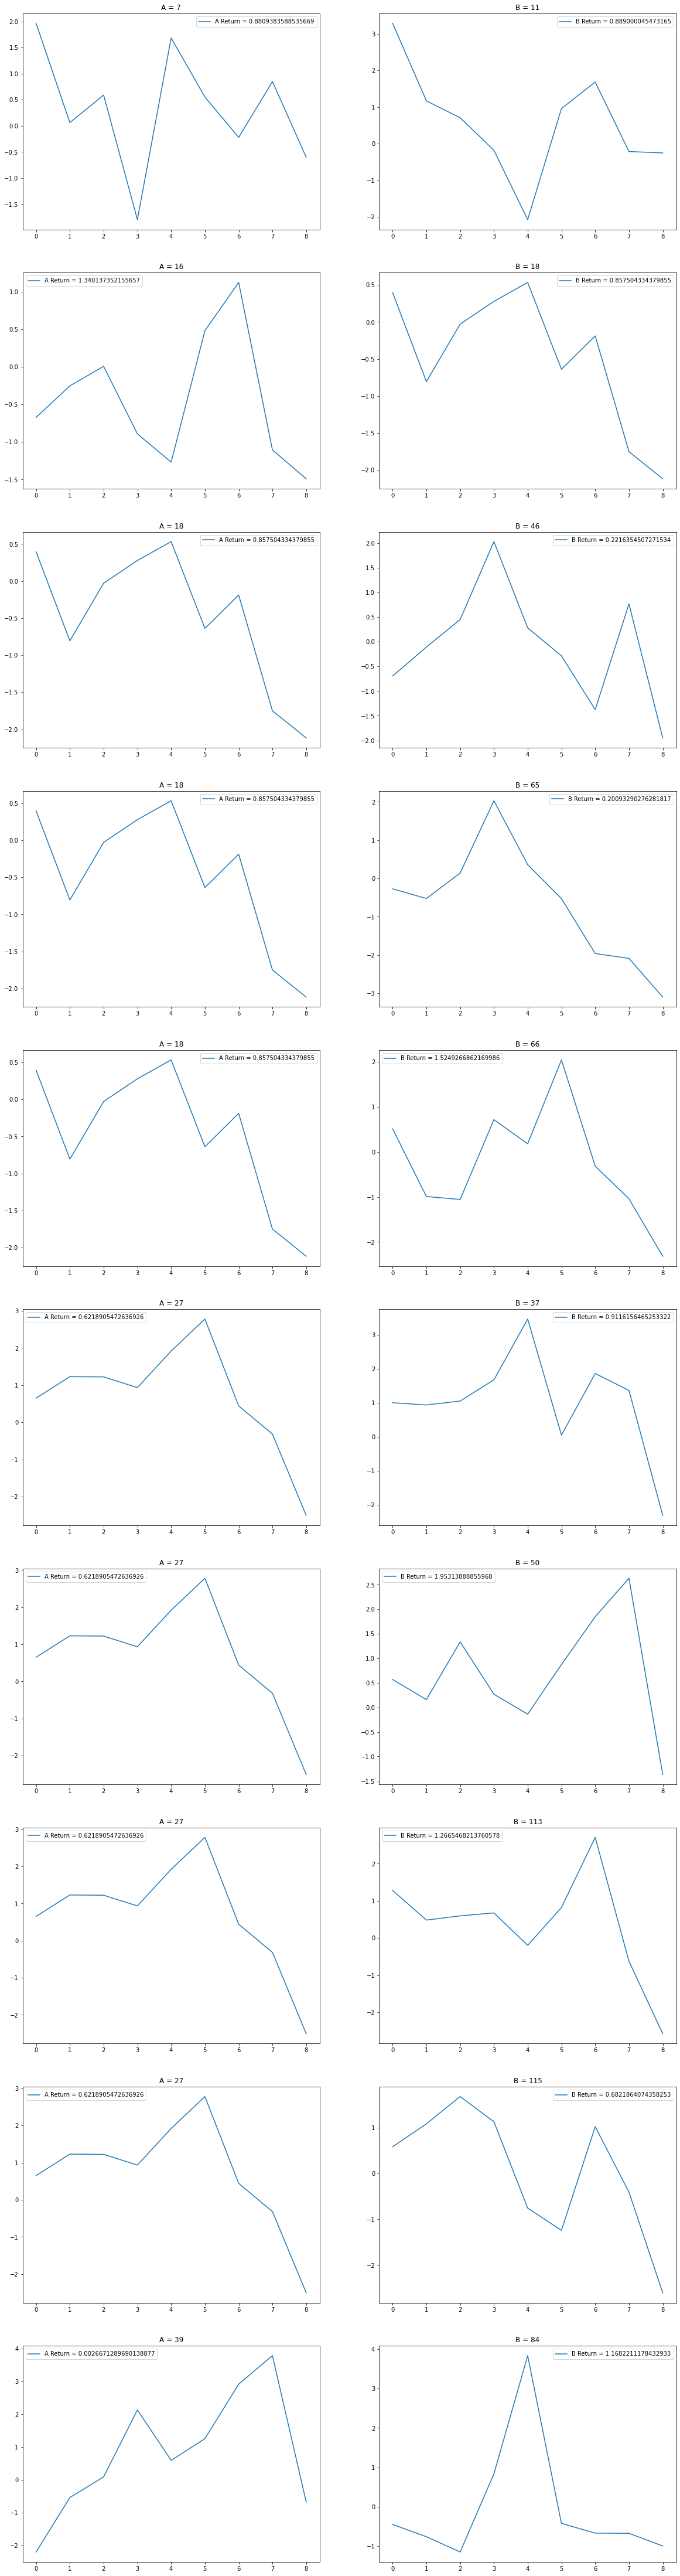

In [15]:
percentDiff = 0
figure, axis = plt.subplots(10, 2,figsize=(20, 80))

for i in range(len(returnList)):
    if returnList[i][0] > returnList[i][1]:
        percentDiff += abs(((returnList[i][0]-returnList[i][1])/ returnList[i][0]*100.0)-100)
    else:
        percentDiff += abs(((returnList[i][1]-returnList[i][0])/returnList[i][1]*100.0)-100)
    
    # Print the first 10 Distance Pairs
    if i < 10:
        axis[i][0].set_title('A = {}'.format(int(returnList[i][2])))
        axis[i][0].plot(np.arange(numDays-1), timeSeries[int(returnList[i][2])][0])
        axis[i][0].legend(['A Return = {}'.format(returnList[i][1])])
        axis[i][1].set_title('B = {}'.format(int(returnList[i][3])))
        axis[i][1].plot(np.arange(numDays-1), timeSeries[int(returnList[i][3])][0])
        axis[i][1].legend(['B Return = {}'.format(returnList[i][0])])

print('Average Percent Accuracy: ', percentDiff/len(returnList))